In [1]:
from policyengine_uk import Microsimulation
from policyengine_core.reforms import Reform
import plotly.graph_objects as go
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import zipfile
import os

In [11]:
baseline = Microsimulation()
# reformed = Microsimulation(reform=reform)
baseline_income = baseline.calculate("real_household_net_income", period=2024)
# reformed_income = reformed.calculate("real_household_net_income", period=2029)
baseline_people = baseline.calculate("people", map_to = "household", period=2024)
# reformed_people = baseline.calculate("people", map_to = "household", period=2029)

In [12]:
hex_locations = pd.read_csv('hex_map_LA.csv')
age_df = pd.read_csv('../targets/age.csv')
with h5py.File("../targets/weights.h5", "r") as f:
    weights = f["weight"][:]

In [13]:
income_2024 = np.dot(weights, baseline_income.values)
population_2024 = np.dot(weights, baseline_people.values)  
per_capita_2024 = income_2024 / population_2024

In [14]:
df = pd.DataFrame({
    'code': age_df['code'],
    'name': age_df['name'],
    'income': per_capita_2024
})
df = df.rename(columns={'code': 'LAD24CD'})

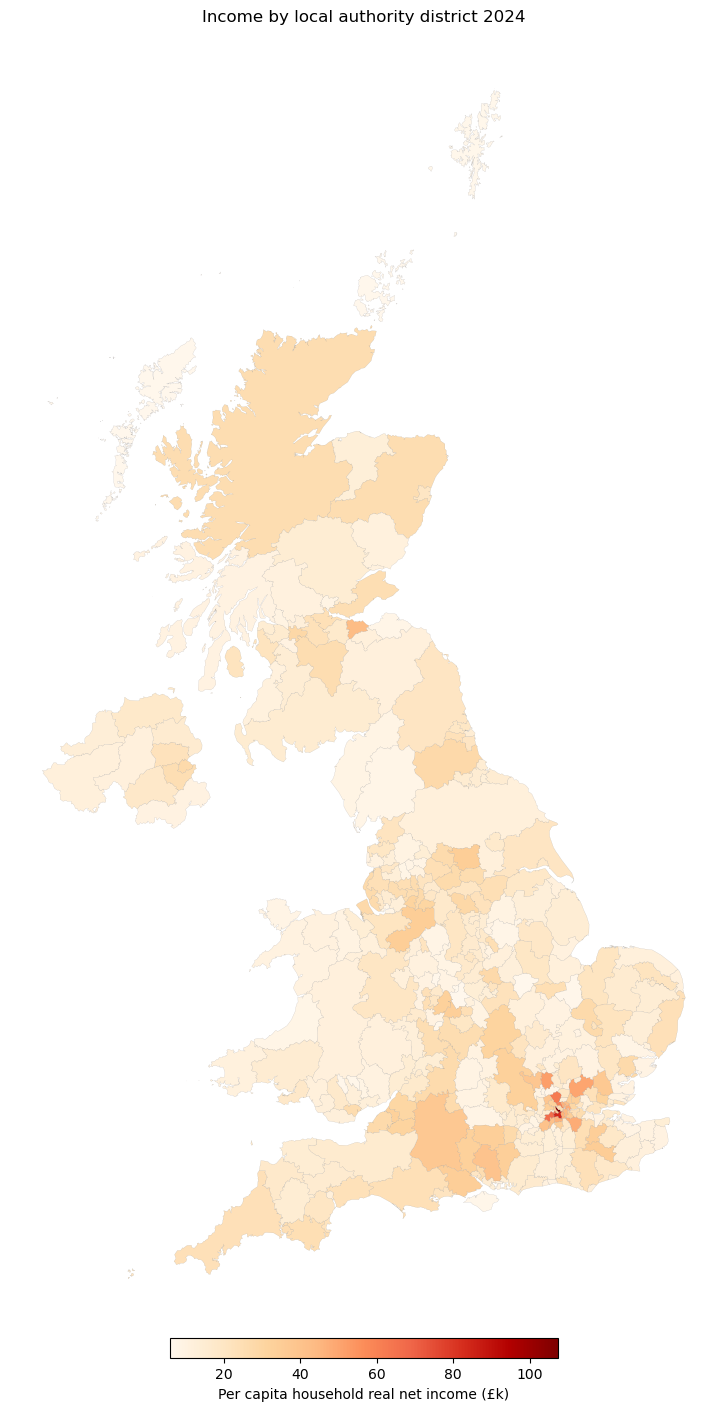

In [20]:
# Path to the zip file
zip_file_path = "Local_Authority_2024_Boundaries.zip"

# Extract the zip file
extracted_folder = "extracted_shapefile"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Find the .shp file in the extracted folder
shapefile_path = None
for root, dirs, files in os.walk(extracted_folder):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            
if shapefile_path:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    lad_income_copy = df.copy()  # Create a copy of the lad_income DataFrame
    lad_income_copy['income'] = lad_income_copy['income'] / 1000  # Convert to thousands

    # Merge GeoDataFrame with income data
    merged_gdf = gdf.merge(lad_income_copy, on="LAD24CD", how="left")

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    merged_gdf.plot(
        column="income", 
        cmap="OrRd", 
        linewidth=0.08, 
        ax=ax, 
        edgecolor="0.5", 
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',  # Set legend orientation to horizontal
            'shrink': 0.5,                # Adjust size of the legend
            'pad': 0.0,                   # Add space between the legend and map
            'label': 'Per capita household real net income (£k)'  # Add a label for the legend
        }
    )
    ax.axis('off')  # Remove axes
    plt.title("Income by local authority district 2024")
    plt.show()
else:
    print("No shapefile (.shp) found in the ZIP archive.")
